In [6]:
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)

Mounted at /content/drive


In [3]:
!pip install tableone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from google.colab import drive
from tableone import TableOne
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression


# 1. Data Cleaning

First, we take a very basic look at the first 20 rows of the table to get a sense of the data:

In [7]:
data = pd.read_csv('/content/drive/My Drive/data.csv')
print(data.shape)
print(data.head(20))

(1549, 90)
   subject_id  is_eligible  days_since_enrollment    cohort  brthdat_coded  \
0    101-0001         True                   -1.0  Cohort 1            NaN   
1    101-0001         True                    0.0  Cohort 1            NaN   
2    101-0001         True                    1.0  Cohort 1            NaN   
3    101-0001         True                    2.0  Cohort 1            NaN   
4    101-0001         True                    3.0  Cohort 1            NaN   
5    101-0001         True                    4.0  Cohort 1            NaN   
6    101-0001         True                    5.0  Cohort 1            NaN   
7    101-0001         True                    6.0  Cohort 1            NaN   
8    101-0001         True                    7.0  Cohort 1            NaN   
9    101-0001         True                    8.0  Cohort 1            NaN   
10   101-0001         True                    9.0  Cohort 1            NaN   
11   101-0001         True                   10.0  Co

The above told us that there are a LOT of columns. Let us describe all of them for a very quick eyeball of value distributions:

In [8]:
data_summary = data.describe(include='all')
data_summary

,subject_id,is_eligible,days_since_enrollment,cohort,brthdat_coded,age,sex,sex_coded,dmcbpot_coded,ethnicity,race,race_coded,race_other,raceoth_coded,race_ethnicity,vsdat,vsdat_coded,vstim,vstim_coded,vsht_coded,vshtu,vshtu_coded,vswt,vswt_coded,vswtu,vswtu_coded,baseline_bmi,vsbmi_coded,vssysbp,vssysbp_coded,vsdiabp,vsdiabp_coded,vsbpnd,vsbpnd_coded,vspulse,vspulse_coded,prnd,prnd_coded,vsrr,vsrr_coded,rrnd,rrnd_coded,oxsat,oxsat_coded,osnd,osnd_coded,vstemp,vstemp_coded,vstempu,vstempu_coded,tempnd,tempnd_coded,height_m,date,date_local,lead_on_hours,noisy_hours,activity_hours,mean_sleep_hr,mean_sleep_rr,sd_sleep_hr,sd_sleep_rr,max_resting_hr,max_active_hr,max_mean_1min_hr,min_mean_1min_hr,max_mean_1min_night_hr,min_mean_1min_night_hr,max_mean_5min_hr,min_mean_5min_hr,max_mean_5min_night_hr,min_mean_5min_night_hr,af_burden_pct,num_nsvt_events,num_st_changes,num_st_change_events,mean_abs_max_displacement_uv,sd_abs_max_displacement_uv,min_max_displacement_uv,max_max_displacement_uv,max_ventricular_rate_bpm,mean_temperature_c,sd_temperature_c,mean_heart_rate_variability_ms,sd_heart_rate_variability_ms,mean_systolic_bp,mean_diastolic_bp,mean_weight_kg,kccq_summary_score,ejection_fraction
count,1549,1549,1399.000000,1368,0.0,1368.000000,1368,1368.000000,730.000000,1368,1368,1368.000000,0.0,0.0,1368,1368,0.0,1368,0.0,0.0,1368,1368.0,1368.000000,0.0,1368,1368.0,1368.000000,0.0,1368.000000,0.0,1368.000000,0.0,1368,1368.0,1368.000000,0.0,1368,1368.0,1368.000000,0.0,1368,1368.0,1345.000000,0.0,1368,1368.000000,1368.000000,0.0,1368,1368.0,1368,1368.0,1368.000000,1549,1549,791.000000,791.000000,791.000000,696.000000,697.000000,696.000000,697.000000,789.000000,789.000000,789.000000,789.000000,696.000000,696.000000,789.000000,789.000000,696.000000,696.000000,791.000000,791.000000,791.0,791.000000,622.000000,561.000000,622.000000,622.000000,321.000000,791.000000,791.000000,791.000000,791.000000,785.000000,785.000000,784.000000,39.000000,1352.000000
unique,72,2,NaN,4,NaN,NaN,2,NaN,NaN,2,4,NaN,NaN,NaN,5,54,NaN,55,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,2,NaN,NaN,NaN,1,NaN,1,NaN,NaN,177,177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,101-0067,True,NaN,Cohort 1,NaN,NaN,Female,NaN,NaN,Not Hispanic or Latino,White,NaN,NaN,NaN,White,3/27/23,NaN,11:44:00,NaN,NaN,in,NaN,NaN,NaN,lb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,No,NaN,NaN,NaN,No,NaN,NaN,NaN,No,NaN,NaN,NaN,°F,NaN,No,NaN,NaN,3/11/23,3/11/23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,30,1323,NaN,484,NaN,NaN,730,NaN,NaN,1265,971,NaN,NaN,NaN,868,58,NaN,60,NaN,NaN,1368,NaN,NaN,NaN,1368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1368,NaN,NaN,NaN,1368,NaN,NaN,NaN,1368,NaN,NaN,NaN,1345,NaN,NaN,NaN,1368,NaN,1368,NaN,NaN,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.938528,NaN,NaN,57.999269,NaN,1.533626,0.345205,NaN,NaN,4.361111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,195.688138,NaN,NaN,2.0,30.700877,NaN,130.649935,NaN,79.942249,NaN,NaN,0.0,71.040515,NaN,NaN,0.0,15.210216,NaN,NaN,0.0,97.879607,NaN,NaN,0.016813,98.293808,NaN,NaN,2.0,NaN,0.0,1.703083,NaN,NaN,20.293010,0.152452,2.354420,66.282615,16.978773,6.248591,2.274444,164.397715,165.197555,138.852374,55.147271,95.099161,56.806256,122.762754,57.309506,84.605143,58.685656,7.896744,7.712568,0.0,76.801016,217.571151,98.686451,-212.842932,412.541545,139.778489,32.984642,1.072045,68.921883,47.389524,129.619422,78.777248,87.031876,90.172784,56.910285
std,NaN,NaN,9.282897,NaN,NaN,16.913027,NaN,0.499050,0.475761,NaN,NaN,1.038967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,49.734863,NaN,NaN,0.0,7.735318,NaN,20.990805,NaN,12.167352,NaN,NaN,0.0,12.259127,NaN,NaN,0.0,2.113435,NaN,NaN,0.0,1.270242,NaN,NaN,0.128617

After a quick look above, seems like there are a lot of empty columns. So I am going to choose to remove them to slim down the dataset, bringing it to 76 columns instead of 90

In [9]:
non_empty_cols = data_summary.loc['count'] > 0
print(non_empty_cols)
data_no_empty_cols = data.loc[:, non_empty_cols]


print("number of columns after removing empties: " + str(data_no_empty_cols.shape[1]))

subject_id                True
is_eligible               True
days_since_enrollment     True
cohort                    True
brthdat_coded            False
                         ...  
mean_systolic_bp          True
mean_diastolic_bp         True
mean_weight_kg            True
kccq_summary_score        True
ejection_fraction         True
Name: count, Length: 90, dtype: bool
number of columns after removing empties: 76


In [10]:
numeric_df = data_no_empty_cols.select_dtypes(include=[np.number])
categorical_df = data_no_empty_cols.select_dtypes(exclude=[np.number])

print(f"Numeric columns: {numeric_df.shape[1]}")
print(f"Categorical columns: {categorical_df.shape[1]}")

Numeric columns: 57
Categorical columns: 19


I want to get a closer look at values to see if there are any obvious coding issues or strange values. So I split the dataset into categorical and numeric variables so that the describe is a little cleaner:

In [11]:
numeric_df.describe()

,days_since_enrollment,age,sex_coded,dmcbpot_coded,race_coded,vshtu_coded,vswt,vswtu_coded,baseline_bmi,vssysbp,vsdiabp,vsbpnd_coded,vspulse,prnd_coded,vsrr,rrnd_coded,oxsat,osnd_coded,vstemp,vstempu_coded,tempnd_coded,height_m,lead_on_hours,noisy_hours,activity_hours,mean_sleep_hr,mean_sleep_rr,sd_sleep_hr,sd_sleep_rr,max_resting_hr,max_active_hr,max_mean_1min_hr,min_mean_1min_hr,max_mean_1min_night_hr,min_mean_1min_night_hr,max_mean_5min_hr,min_mean_5min_hr,max_mean_5min_night_hr,min_mean_5min_night_hr,af_burden_pct,num_nsvt_events,num_st_changes,num_st_change_events,mean_abs_max_displacement_uv,sd_abs_max_displacement_uv,min_max_displacement_uv,max_max_displacement_uv,max_ventricular_rate_bpm,mean_temperature_c,sd_temperature_c,mean_heart_rate_variability_ms,sd_heart_rate_variability_ms,mean_systolic_bp,mean_diastolic_bp,mean_weight_kg,kccq_summary_score,ejection_fraction
count,1399.000000,1368.000000,1368.000000,730.000000,1368.000000,1368.0,1368.000000,1368.0,1368.000000,1368.000000,1368.000000,1368.0,1368.000000,1368.0,1368.000000,1368.0,1345.000000,1368.000000,1368.000000,1368.0,1368.0,1368.000000,791.000000,791.000000,791.000000,696.000000,697.000000,696.000000,697.000000,789.000000,789.000000,789.000000,789.000000,696.000000,696.000000,789.000000,789.000000,696.000000,696.000000,791.000000,791.000000,791.0,791.000000,622.000000,561.000000,622.000000,622.000000,321.000000,791.000000,791.000000,791.000000,791.000000,785.000000,785.000000,784.000000,39.000000,1352.000000
mean,1.938528,57.999269,1.533626,0.345205,4.361111,2.0,195.688138,2.0,30.700877,130.649935,79.942249,0.0,71.040515,0.0,15.210216,0.0,97.879607,0.016813,98.293808,2.0,0.0,1.703083,20.293010,0.152452,2.354420,66.282615,16.978773,6.248591,2.274444,164.397715,165.197555,138.852374,55.147271,95.099161,56.806256,122.762754,57.309506,84.605143,58.685656,7.896744,7.712568,0.0,76.801016,217.571151,98.686451,-212.842932,412.541545,139.778489,32.984642,1.072045,68.921883,47.389524,129.619422,78.777248,87.031876,90.172784,56.910285
std,9.282897,16.913027,0.499050,0.475761,1.038967,0.0,49.734863,0.0,7.735318,20.990805,12.167352,0.0,12.259127,0.0,2.113435,0.0,1.270242,0.128617,0.438529,0.0,0.0,0.102894,5.944457,0.653732,1.486518,10.607398,2.146070,4.582679,0.736728,40.141407,41.348936,37.268664,10.289640,27.294552,9.417052,34.253421,10.338377,23.120600,9.597410,23.928104,75.346085,0.0,107.814328,97.575801,80.713809,313.674460,443.915049,41.428575,1.528882,0.441735,51.088960,33.788566,22.002554,12.084777,23.660657,11.812561,6.473829
min,-37.000000,18.000000,1.000000,0.000000,1.000000,2.0,109.104768,2.0,19.600000,94.592794,50.597672,0.0,46.237993,0.0,11.835759,0.0,94.992259,0.000000,97.568978,2.0,0.0,1.471048,-0.547275,-0.089013,-0.025371,41.632954,11.791718,0.486946,-0.023117,66.592759,58.962876,54.603610,38.808202,50.817769,39.117207,49.931613,39.532532,46.661759,39.646841,-2.518566,-8.544040,0.0,-7.149585,96.902982,-1.815034,-2226.948784,-1019.194190,66.246702,17.555514,-0.037954,-3.772786,-0.420510,83.622994,48.376444,5.120437,59.523953,34.902448
25%,-3.000000,47.000000,1.000000,0.000000,3.000000,2.0,148.128527,2.0,25.200000,114.720555,71.540228,0.0,62.027764,0.0,13.939533,0.0,96.980429,0.000000,98.004290,2.0,0.0,1.647317,19.565303,-0.011754,1.318799,59.641353,15.282648,3.963691,1.783287,131.681018,131.312672,109.834216,48.021669,78.571842,50.231266,99.968093,50.408499,70.732316,52.032004,-0.240602,-1.602682,0.0,2.892628,148.871923,41.772880,-321.824673,171.395361,105.486009,32.320052,0.807719,36.545882,25.678021,114.631479,70.662125,68.061087,80.408928,54.794392
50%,3.000000,62.000000,2.000000,0.000000,5.000000,2.0,190.556253,2.0,28.900000,132.043166,82.229070,0.0,68.184316,0.0,15.975808,0.0,98.016762,0.000000,98.226076,2.0,0.0,1.675431,23.462067,0.007833,2.090794,65.760027,16.768537,5.425075,2.174587,162.147112,163.464828,128.863205,55.846628,89.129623,57.760178,113.592575,58.395458,81.637186,59.528548,0.299314,1.581784,0.0,21.587742,192.400916,82.177785,-175.9117

In [12]:
categorical_df.describe()

,subject_id,is_eligible,cohort,sex,ethnicity,race,race_ethnicity,vsdat,vstim,vshtu,vswtu,vsbpnd,prnd,rrnd,osnd,vstempu,tempnd,date,date_local
count,1549,1549,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368,1368,1549,1549
unique,72,2,4,2,2,4,5,54,55,1,1,1,1,1,2,1,1,177,177
top,101-0067,True,Cohort 1,Female,Not Hispanic or Latino,White,White,3/27/23,11:44:00,in,lb,No,No,No,No,°F,No,3/11/23,3/11/23
freq,30,1323,484,730,1265,971,868,58,60,1368,1368,1368,1368,1368,1345,1368,1368,20,20


Splitting the dataset made a few things more obvious:


*   Several categorical variables have single values all the way through. Many variables that fall into this category are related to units
*   Several variables have a coded and non-coded version, which is somewhat redundant.
*   Days since enrollment can be negative, which is important context when defining "baseline"
* There are some negative values in noisy_hours, activity_hours, lead_on_hours, hrv, and a few columns that relate to num_events. I can't think of a real world scenario in which these values would be negative, but I am going to keep them in the dataset for this model, biasing towards real world conditions as opposed to perfectly clean dataset.
* EF is a numeric value. Our task is to predict EF < 50, so it will need to be coded into binary categories



Knowing that our analysis involves regression influences what variables we keep in our analytical dataset. I am choosing to remove:

* any row where is_eligible = False (appears to be assigned at the patient level)

* cohort variable-- since we have no information on the different cohorts, I am choosing to treat population as one cohort

*   Any variable related to units, as they are uniform for all records in this dataset

* Any variable that has a "coded" version (keep only the coded version)

* All categorical variables related to date and time: days_since_enrollment provides us relative day information

*   Since this is a simple, initial model, I am going to keep in race_coded and exclude categorical ethnicity. ethnicity can be added in later for more granularity if desired.


Taking all of this together, we retain most of the numerical df and discard the categorical df except for subject_id and is_eligible









In [13]:
# remove unwanted columns
selected_numeric_cols = numeric_df.drop(columns = ['vshtu_coded', 'vswtu_coded', 'vstempu_coded'])
selected_categorical_cols = categorical_df[['subject_id', 'is_eligible']]

#rejoin into single dataframe, pre-emptively name _57_cols because we're adding a binary col right after
data_57_cols = pd.concat([selected_numeric_cols, selected_categorical_cols], axis=1)
print(data_57_cols.shape)

(1549, 56)


In [14]:
#create new variable binary_ef_less_than_50
data_57_cols['binary_ef_less_than_50'] = np.where(data_57_cols['ejection_fraction'] < 50, 1, 0)
print(data_57_cols['subject_id'].nunique())
print(data_57_cols.shape)

72
(1549, 57)


In [15]:
#exclude rows that happened before study start and patients who are ineligible
data_at_or_after_study_start = data_57_cols[
    (data_57_cols['days_since_enrollment'] > 0) &
    (data_57_cols['is_eligible'] == True)
]

#check shape after removing negative enrollment days and ineligible patients
print(data_at_or_after_study_start.shape)

(825, 57)


This is the point at which I am choosing to create my analytical dataset. I want to use un-imputed data in my xgboost model, so I am not including the imputation transformations to the saved dataset. My analytical dataset ends up being 825 rows and 57 columns.

In [33]:
#save data to csv
data_at_or_after_study_start.to_csv('/content/drive/My Drive/analytic_dataset.csv', index=True)

# 2. Table 1

Below I create the subset of data used for the Table1. I defined "baseline" as the earliest day after day 0 (days_since_enrollment >=0) , and excluded any measurements taken prior to that. I also removed any subject_ids with is_eligible = False, assuming this means they are not eligible for this study.

In [16]:

#check num of unique patients
print(data_at_or_after_study_start['subject_id'].nunique())

#index of minimum date per patient
idx = data_at_or_after_study_start.groupby('subject_id')['days_since_enrollment'].idxmin()

#use indices from above to select row with minimum days_since_enrollment >=0 as baseline
df_one_row_per_patient = data_at_or_after_study_start.loc[idx].reset_index(drop=True)

#check shape. n=58 indicates 14 patients were ineligible and/or had only negative days_since_enrollment
print(df_one_row_per_patient.shape)


58
(58, 57)


In [17]:
#rejoin in sex and race for tableone purposes
demographics = categorical_df[['subject_id', 'race', 'sex']].drop_duplicates(subset='subject_id')

tableone_table = df_one_row_per_patient.merge(demographics, on='subject_id', how='left')

tableone_columns = ['age', 'sex', 'race', 'baseline_bmi',  'oxsat', 'vssysbp', 'vsdiabp', 'mean_heart_rate_variability_ms', 'lead_on_hours']
categorical = ['sex', 'race']
rename = {'baseline_bmi': 'bmi', 'oxsat': 'oxygen saturation', 'vssysbp': 'systolic bp', 'vsdiabp':'diastolic bp', 'mean_heart_rate_variability_ms': 'mean hrv', 'lead_on_hours': 'num of hours with lead on'}

In [18]:
mytableone = TableOne(tableone_table, columns=tableone_columns, categorical=categorical, rename=rename, groupby= 'binary_ef_less_than_50', pval=True)
print(mytableone.tabulate(tablefmt = "fancy_grid"))

╒══════════════════════════════════════╤══════════════════════════════════╤═══════════╤══════════════╤══════════════╤══════════════╤═══════════╕
│                                      │                                  │ Missing   │ Overall      │ 0            │ 1            │ P-Value   │
╞══════════════════════════════════════╪══════════════════════════════════╪═══════════╪══════════════╪══════════════╪══════════════╪═══════════╡
│ n                                    │                                  │           │ 58           │ 51           │ 7            │           │
├──────────────────────────────────────┼──────────────────────────────────┼───────────┼──────────────┼──────────────┼──────────────┼───────────┤
│ age, mean (SD)                       │                                  │ 0         │ 57.2 (18.4)  │ 57.0 (18.6)  │ 58.6 (18.1)  │ 0.835     │
├──────────────────────────────────────┼──────────────────────────────────┼───────────┼──────────────┼──────────────┼─────────────

This table shows the makeup of the two groups of patients, the 1 group being those who have ef < 50 at baseline, and 0 being those who have ef >= 50 at baseline. While there are visual differences in some of the variables, such as mean hrv and bmi p-values indicate the differences are not significant. Important to note the imbalanced groups, this affects performance later when we are modeling the data, there are many more patients with ef >= 50 than patients with ef < 50 at baseline. These values look reasonable and appropriate given what I know about real world values of these metrics.

# 3. Data Viz

I'm really interested in potential relationships between hrv and EF because I did a project investigating hrv and EEG relationships in schizophrenic patients way back in undergrad. I want to see the variability of mean hrv across patients in this cohort, and also want to see if there is an obvious visual relationship between mean hrv and EF. For simplicity, I am just looking at baseline at the moment since that dataframe is already available to me. I also am choosing to split out men and women to highlight any relationships related to sex.

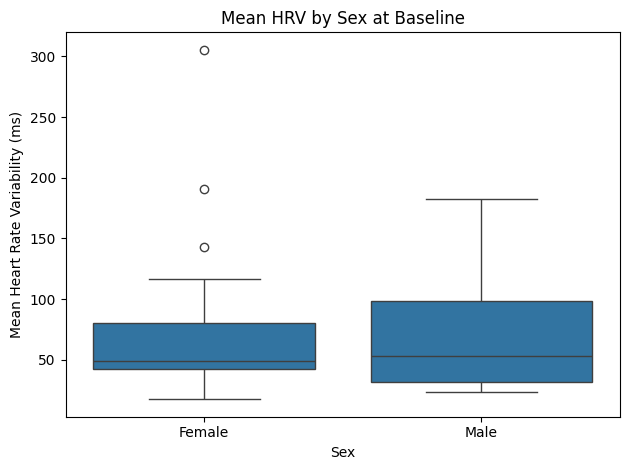

In [19]:
#boxplot by sex of mean hrv at baseline. reuse tableone table because it has everything we need

sns.boxplot(data=tableone_table, x='sex', y='mean_heart_rate_variability_ms')
plt.title('Mean HRV by Sex at Baseline')
plt.xlabel('Sex')
plt.ylabel('Mean Heart Rate Variability (ms)')
plt.tight_layout()
plt.show()

From the above boxplot, we can see that the mean baseline HRV is close in both males and females, but males in our cohort have a wider range of mean hrv. The outliers in the female side of the boxplot are pretty high, but still technically physologically possible.  

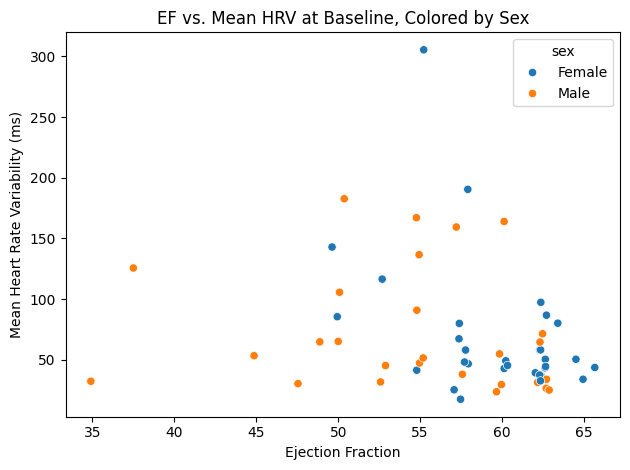

In [20]:
#scatterplot of mean hrv and EF, color coded by sex

sns.scatterplot(
    data=tableone_table,
    x= 'ejection_fraction',
    y= 'mean_heart_rate_variability_ms',
    hue='sex'
)
plt.title('EF vs. Mean HRV at Baseline, Colored by Sex')
plt.xlabel('Ejection Fraction')
plt.ylabel('Mean Heart Rate Variability (ms)')
plt.tight_layout()
plt.show()

This scatterplot tells a similar visual story to the boxplot: EF and HRV coupled seem to cluster more for females than males. Future investigation would include a line of best fit and a p-value to see if there is any significant linear relationship between these two variables for males or females.

# 4a. Regression

The below code helps me choose an imputation strategy for variables for my regression model.


*   Since kccq score is missing a ton of data,  I am going to drop it.
*  While max ventricular rate bpm is useful, we have a lot of related rate data and at 64% missingness I am not particularly worried about data loss from dropping this variable.
*   I am not particularly interested in childbearing potential for this model, so I will also drop dmcbpot_coded
* The rest of the data has moderate to low missingness, upt to 36%, I am choosing to impute with the per patient mean so that this data can fit into regression model



In [21]:
na_summary = data_at_or_after_study_start.isnull().sum().to_frame(name='n_missing')
na_summary['pct_missing'] = data_at_or_after_study_start.isnull().mean() * 100
na_summary = na_summary.sort_values(by='pct_missing', ascending=False)

na_summary

,n_missing,pct_missing
kccq_summary_score,795,96.363636
max_ventricular_rate_bpm,529,64.121212
dmcbpot_coded,381,46.181818
sd_abs_max_displacement_uv,303,36.727273
mean_abs_max_displacement_uv,249,30.181818
max_max_displacement_uv,249,30.181818
min_max_displacement_uv,249,30.181818
sd_sleep_hr,131,15.878788
mean_sleep_hr,131,15.878788
min_mean_1min_night_hr,131,15.878788


In [22]:
modeling_data_imputed = data_at_or_after_study_start.drop(columns=['kccq_summary_score', 'max_ventricular_rate_bpm', 'dmcbpot_coded'])

vars_to_impute = na_summary[
    (na_summary['pct_missing'] < 37) &
    (na_summary['pct_missing'] > 1)
].index.tolist()

for col in vars_to_impute:
    modeling_data_imputed[col] = modeling_data_imputed.groupby('subject_id')[col].transform(lambda x: x.fillna(x.mean()))
    modeling_data_imputed[col] = modeling_data_imputed[col].fillna(modeling_data_imputed[col].mean())  #option: fallback to overall mean


We are predicting binary outcomes at each timepoint for this analysis,  EF <50 (1) or EF >= 50 (0), so we use logistic regression. Several caveats here:
*   I suspect the dataset is highly imbalanced, given what we saw above in the baseline data visualizations.

*    I also chose to keep most variables in the dataset, so there will likely be a lot of noise given that I haven't identified any irrelevant variables.


*   This is longitudinal patient data, and patients will have multiple timepoints to predict ef at--this means there are going to be relationships between variables.

For time purposes, and since this is an initial model of the data, I am going to see how models perform on all the data as a learning excercise to give a starting point for theoretical future iterations on the data and the model. I am not expecting great performance at this point.

In [23]:
#create groups to avoid data leakage. We are predictig ef for each timepoint
#in the dataset, so patients will have multiple predictions, but this should ensure all of a patient's data is in either test or train
groups = data_at_or_after_study_start['subject_id']

#since we want to use imputed data for regression and non-imputed for xgboost, X is different from both. y will be the same
X_reg = modeling_data_imputed.drop(columns=['subject_id', 'binary_ef_less_than_50', 'ejection_fraction'])
X_xgb = data_at_or_after_study_start.drop(columns=['subject_id', 'binary_ef_less_than_50', 'ejection_fraction'])

y = data_at_or_after_study_start['binary_ef_less_than_50']

#create stratified folds so that the few ef <50 occurences are distributed across folds
gkf = StratifiedGroupKFold(n_splits=5)

splits = list(gkf.split(X=data_at_or_after_study_start, y=y, groups=groups))

I am evaluating this and the next model for AUC and accuracy. Accuracy is not the best metric to use when you know the dataset is imbalanced, but I was curious regardless.
To use logistic regression on this imbalanced dataset, I am using the class_weight parameter, an l2 penalty, and the liblinear solver. L2 (ridge regression) helps with convergence in small, noisy datasets with multicollinearity--all features our data has. class_weight=balanced gives more weight to the minority class, encouraging learning from them. The liblinear solver is more stable than other choices in small, noisy datasets and works well with l2 and binary classification problems.

In [30]:
auc_scores = []
acc_scores = []


#loop for 5 fold cross validation of this model, evaluating accuracy and AUC
for train_idx, test_idx in splits:
    X_train, X_test = X_reg.iloc[train_idx], X_reg.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


    model = LogisticRegression(penalty = 'l2', solver='liblinear', max_iter=5000, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    auc_scores.append(auc)
    acc_scores.append(acc)

    print(f"Fold AUC: {auc:.3f}, Accuracy: {acc:.3f}")

print(f"\nMean AUC: {np.mean(auc_scores):.3f}")
print(f"Mean Accuracy: {np.mean(acc_scores):.3f}")

Fold AUC: 0.204, Accuracy: 0.701
Fold AUC: 0.536, Accuracy: 0.701
Fold AUC: 0.513, Accuracy: 0.778
Fold AUC: 0.447, Accuracy: 0.586
Fold AUC: 0.468, Accuracy: 0.760

Mean AUC: 0.434
Mean Accuracy: 0.705


Accuracy and AUC show that while the model is fairly accurate (expected due to imbalance), AUC indicates the model is worse at predicting outcomes than random choice.

# 4b. Xgboost

Xgboost may be a better approach for this problem because it allows missing data. I am going to calculate the appropriate weighting for the majority and minority classes and use that in our model to address imbalance.

In [31]:
#calculate negative samples / postive samples
n_pos = sum(y == 1)
n_neg = sum(y == 0)
scale_pos_weight = n_neg / n_pos

In [32]:
auc_scores = []
acc_scores = []

#loop for cross validation of this model, evaluating auc and accuracy

for train_idx, test_idx in splits:
    X_train, X_test = X_xgb.iloc[train_idx], X_xgb.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', n_estimators=100, max_depth=3)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    auc_scores.append(auc)
    acc_scores.append(acc)

    print(f"Fold AUC: {auc:.3f}, Accuracy: {acc:.3f}")

print(f"\nMean AUC: {np.mean(auc_scores):.3f}")
print(f"Mean Accuracy: {np.mean(acc_scores):.3f}")

Fold AUC: 0.024, Accuracy: 0.911
Fold AUC: 0.921, Accuracy: 0.873
Fold AUC: 0.704, Accuracy: 0.825
Fold AUC: 0.014, Accuracy: 0.554
Fold AUC: 0.648, Accuracy: 0.721

Mean AUC: 0.462
Mean Accuracy: 0.777


Ok, xgboost with class weighting improved slightly over regression in terms of AUC and accuracy (pvalue needed to confirm). But obviously more work should be done to make this a useable model. With more time I would like to implement a model that explicitly handles time-series data. I have implemented an LSTM neural network in the past that worked well in learning timepoint-associated relationships.

# Conclusion

Niether of the models created here are useable-- AUC is worse than random choice for both. Several paths forward were identified into tailoring the data and model selection:


*   Slimming down the number of variables
*   More robust approach to class imbalance
*   Model selection more suited for time series-esque data

